# Mediation Data Explorer

Model as bipartite graph. Biadjacency matrix has mediations in rows and actors in cells.


## Vertices

Some network analysis using the following vertices:

- Mediation: we have an integer identifier along with metadata:
    - Date
    - Conflict locale (all Sudan)
    - Conflict sub-locale
    - Location of negotiations
    - Negotiation type
- Actor:
    - Actor identifiers (use value in third-party column)
    - Actor type
    
## Edges

We require edge data because a mediation-actor relationship can take values from:

- Leading actor (Boolean)
- Actor mediation activities (set of Boolean values):
    - Good offices
    - Mediation
    - Hosting
    - Negotiating
    - Manipulating
    - Humanitarian
    
Can model edge data using integer values in matrix cells using decimal value of a binary string of length seven. These integer values are edge weights. Bit order left-to-right is:

- Is lead actor
- Good offices
- Mediation
- Hosting
- Negotiating
- Manipulating
- Humanitarian

## Data structure recommendations




In [1]:
__author__      = 'Roy Gardner'

%run ./mediation_functions.py


## Load the mediation-actor data

- Load data into a biadjacency matrix with mediations in rows and actors in columns
- Matrix values are zero except where a relation between a mediation and an actor exists where the value is an non-zero integer that codes the mediation-actor edge properties.
- Apart from the matrix other data are extracted or computed.
- All data are stored in data_dict




In [2]:

data_path = './data/'
mediation_file = 'mediation.csv'
actors_file = 'actors.csv'

data_dict = load_mediation_data(mediation_file,actors_file,data_path)

print(data_dict['header'])


['year', 'mediation ID', 'negotiation ID', 'conflict locale', 'conflict sub-locale', 'locale Gleditsch ID', 'third-party', 'third-party Gleditsch ID', 'location of neogitations', 'negotiation location Gleditsch ID', 'negotiation type', 'leading actor', 'leading actor 2', 'leading actor 3', 'good offices', 'mediation', 'hosting talks', 'negotiating and drafting', 'manipulating', 'humanitarian', 'witness/party to agreement', 'other', 'agreement', 'peace agreement', 'ceasfire agreement', 'agreement name', 'notes_1', 'source_1', 'note_2', 'source_2', 'note_3', 'source_3', 'note_4', 'source_4', 'note_5', 'source_5', 'Column1', 'Column2', 'Column3', 'Column4', 'Column5', 'Column6', 'Column7', 'Column8', 'Column9', '']


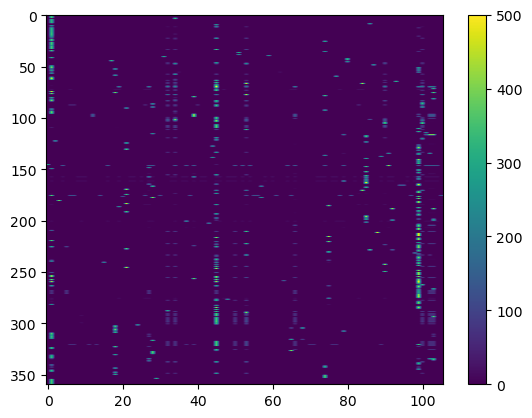

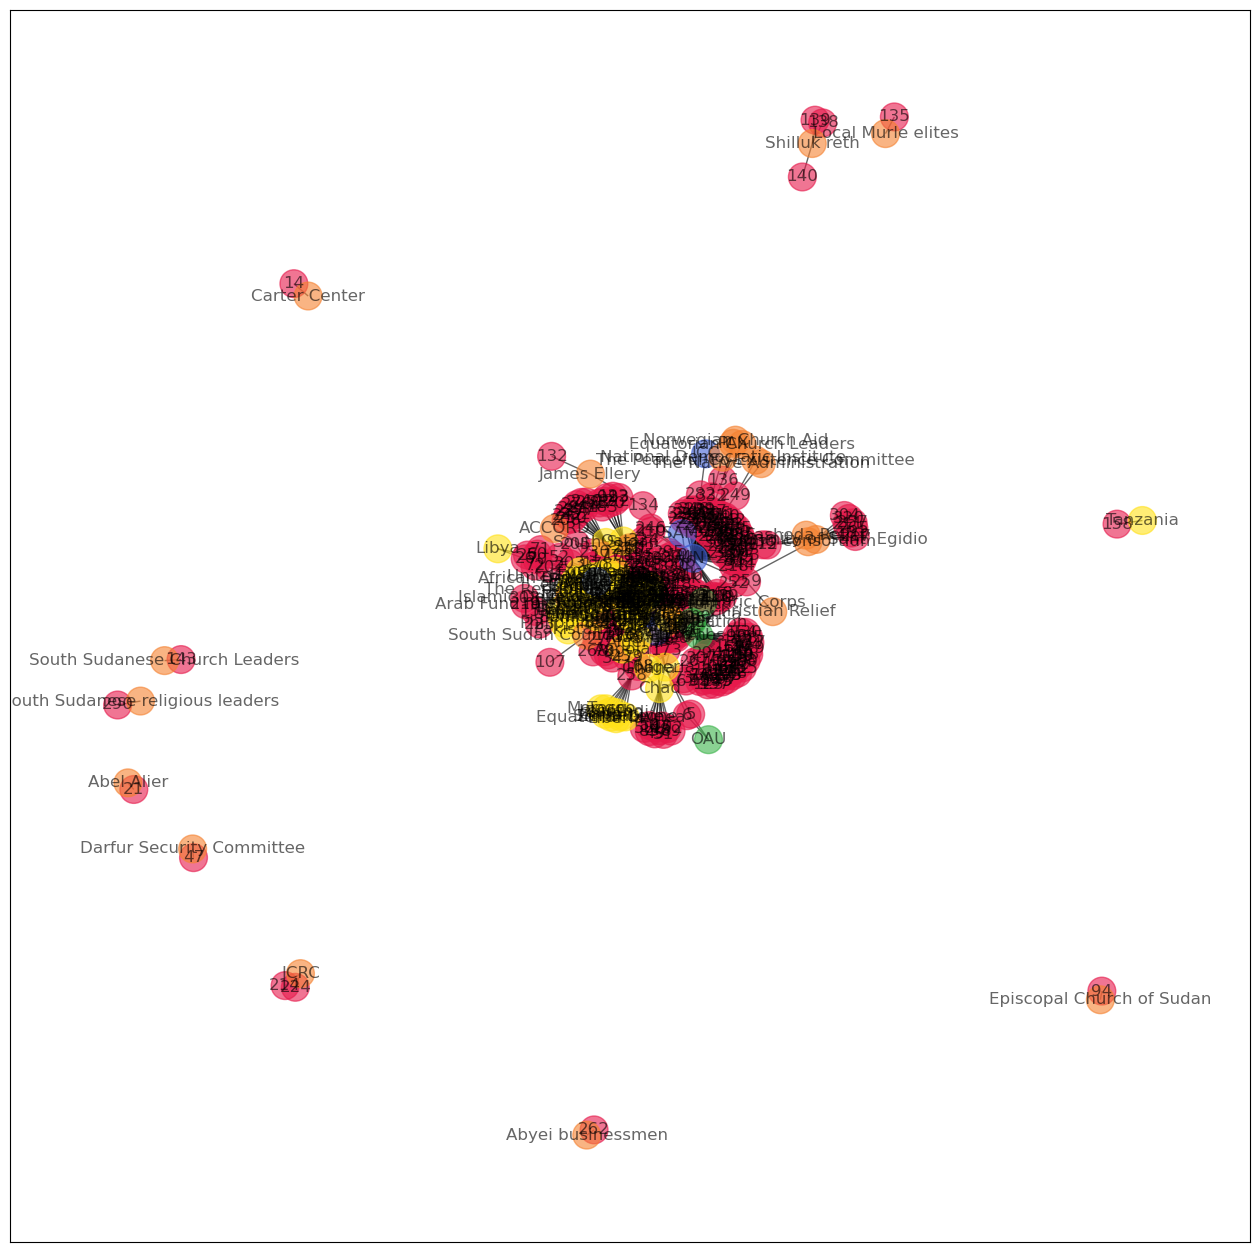

In [3]:
%run ./mediation_functions.py


plt.imshow(data_dict['matrix'],aspect='auto')
plt.colorbar()
plt.show()

adjacency_matrix,adj_vertices = adjacency_from_biadjacency(data_dict)
bin_matrix = (adjacency_matrix > 0).astype(np.int8)

draw_networkx_graph(bin_matrix,adj_vertices,data_dict)


## Query Network

- Example here queries the network for actors.



['Netherlands', 'Germany', 'Italy']


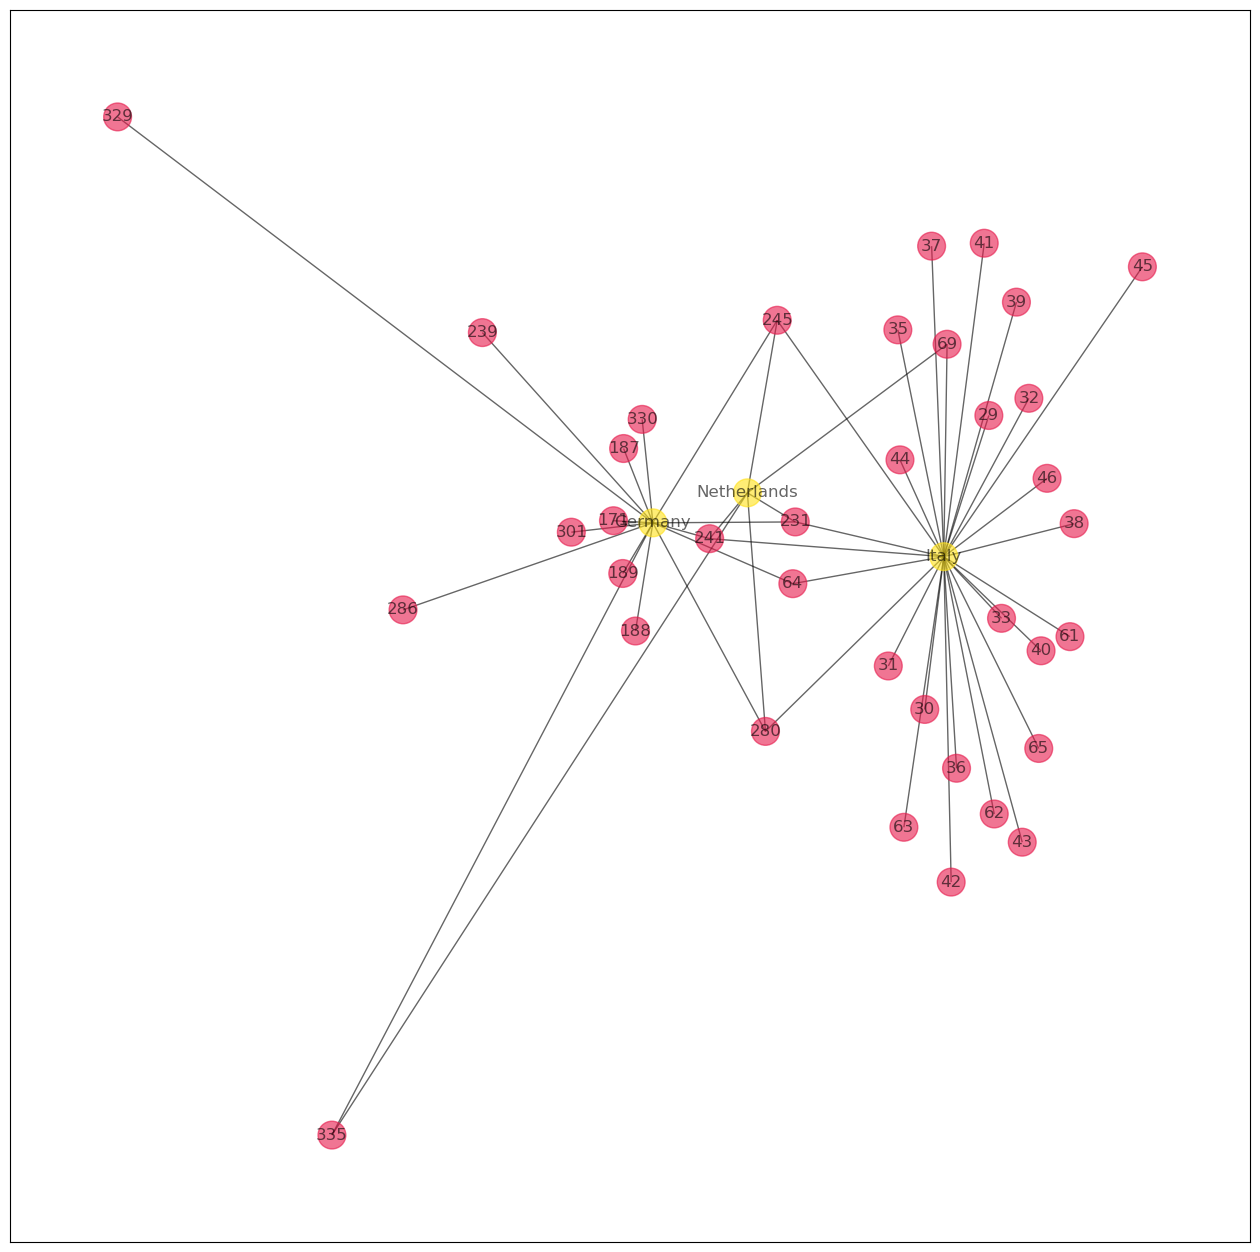

In [4]:
%run ./mediation_functions.py

# Convert a peace process biadjacency matrix to an adjacency matrix
adj_matrix,adj_vertices = adjacency_from_biadjacency(data_dict)

operator = 'OR'

query_vertices = ['Netherlands']
query_vertices = ['IGAD','UN']
query_vertices = ['Netherlands','United States of America']
query_vertices = ['Netherlands','Germany','Italy']
print()
print(query_vertices)

query_indices = [adj_vertices.index(vertex) for vertex in query_vertices]
query_matrix,found_indices = get_query_matrix(query_indices,adj_matrix,operator=operator)
found_vertices = [adj_vertices[index] for i,index in enumerate(found_indices)]


draw_networkx_graph(query_matrix,found_vertices,data_dict)



## Network time series

2022


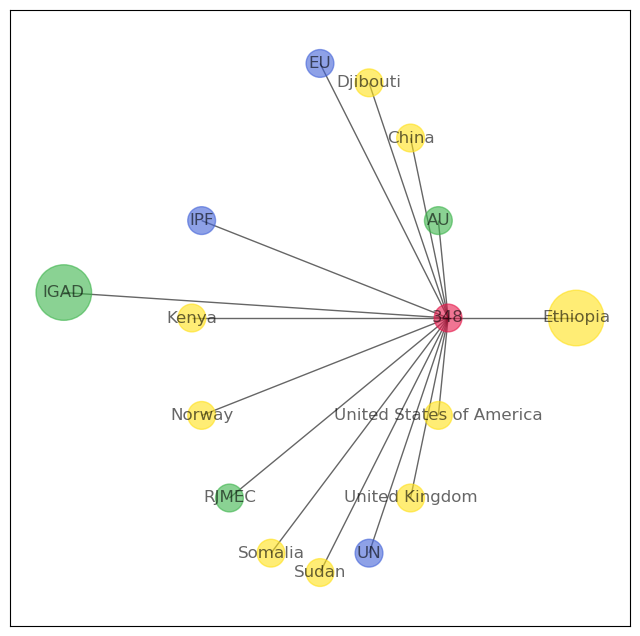

In [5]:

# Decide on an actor
actor_ids = ['IGAD','UN']
actor_ids = ['IGAD','Ethiopia']
#actor_ids = ['AU','Ethiopia']
mediation_ids = get_joint_mediations(actor_ids,data_dict)

all_mediations = False

if all_mediations:
    # Get all mediations for our dates
    dates = []
    for mediation_id in mediation_ids:
        dates.append(data_dict['vertices_dict'][mediation_id]['data']['year'])

    # Get all mediations for a given date
    dates_dict = {}
    for mediation_id in data_dict['mediation_vertices']:
        date = data_dict['vertices_dict'][mediation_id]['data']['year']
        if not date in dates:
            continue
        if date in dates_dict:
            dates_dict[date].append(mediation_id)
        else:
            dates_dict[date]= [mediation_id]
else:        
    # Get dates of joint mediations only
    dates_dict = {}
    for mediation_id in mediation_ids:
        date = data_dict['vertices_dict'][mediation_id]['data']['year']
        if date in dates_dict:
            dates_dict[date].append(mediation_id)
        else:
             dates_dict[date]= [mediation_id]   
        
dates = sorted(dates_dict.items(),key=lambda kv:kv[0])

adj_matrix,adj_vertices = adjacency_from_biadjacency(data_dict)

for t in dates:
    print(t[0])
    mediation_ids = t[1]
    mediation_indices = [data_dict['mediation_vertices'].index(mediation_id) for\
                         mediation_id in mediation_ids]
    actor_indices = []
    for mediation_index in mediation_indices:
        actor_indices.extend([index for index,v in enumerate(data_dict['matrix'][mediation_index]) if\
                                  v>1])
        actor_indices = list(set(actor_indices))
    
    all_actor_ids = [data_dict['actor_vertices'][index] for index in actor_indices]
    
    query_vertices = []
    query_vertices.extend(all_actor_ids)
    query_vertices.extend(mediation_ids)
    query_indices = [adj_vertices.index(vertex) for vertex in query_vertices]
    query_matrix,found_indices = get_query_matrix(query_indices,adj_matrix,operator='AND')
    
    display_networkx_graph_ts(actor_ids,query_matrix,found_indices,adj_vertices,data_dict,title='',file='')
    time.sleep(2)
    clear_output(wait=True)



## Actor engagements over time

(106, 360)


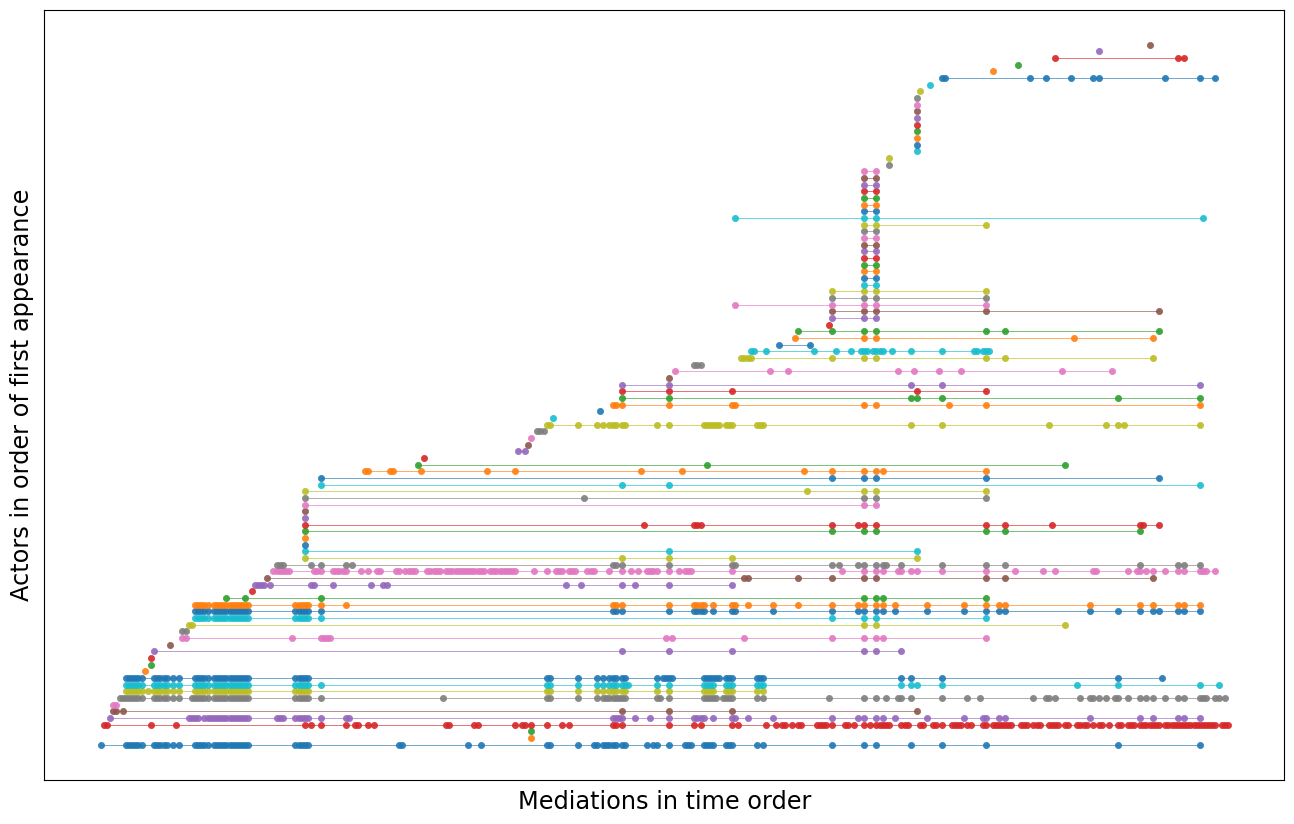

In [6]:
#print(data_dict['dates_dict'])

#print(pp_data_dict['pp_agreement_ids'])
mediation_ids = data_dict['mediation_vertices']

t_list = []
for i,mediation_id in enumerate(mediation_ids):
    mediation_date = data_dict['vertices_dict'][mediation_id]['data']['year']
    t_list.append((i,mediation_date))
# Sort by date    
t_list = sorted(t_list,key=lambda t:t[1])

# Build a time-order mediation-actor matrix
ordered_matrix = []
for t in t_list:
    ordered_matrix.append(data_dict['matrix'][t[0]])
    
ordered_matrix = np.array(ordered_matrix)
# Put actors in rows
ordered_matrix = ordered_matrix.T

print(ordered_matrix.shape)

# Now order actors by first appearance in process
row_indices = []
for i,row in enumerate(ordered_matrix):
    where = np.where(row>1)
    v = 0
    if len(where[0]) > 0:
        v = where[0][0]
    row_indices.append((i,v))
sorted_row_indices = [t[0] for t in sorted(row_indices,key=lambda t:t[1])]

sorted_matrix = ordered_matrix[np.ix_(sorted_row_indices)]

f = plt.figure(figsize=(16,10))
for i,row in enumerate(sorted_matrix):
    x = [j for j,x in enumerate(row) if x > 0]
    y = [i]*len(x)
    plt.scatter(x,y,alpha=0.9,linewidth=0.5,s=20)
    plt.plot(x,y,alpha=0.9,linewidth=0.5)
xint = range(0, sorted_matrix.shape[1])
plt.xticks([],fontsize='xx-large')    
yint = range(0, sorted_matrix.shape[1])
plt.yticks([],fontsize='xx-large')    
plt.ylabel('Actors in order of first appearance',fontsize='xx-large')
plt.xlabel('Mediations in time order',fontsize='xx-large')
plt.show()



## Actor co-occurrence

- Find mediations in common for pairs of actors


(106, 106)


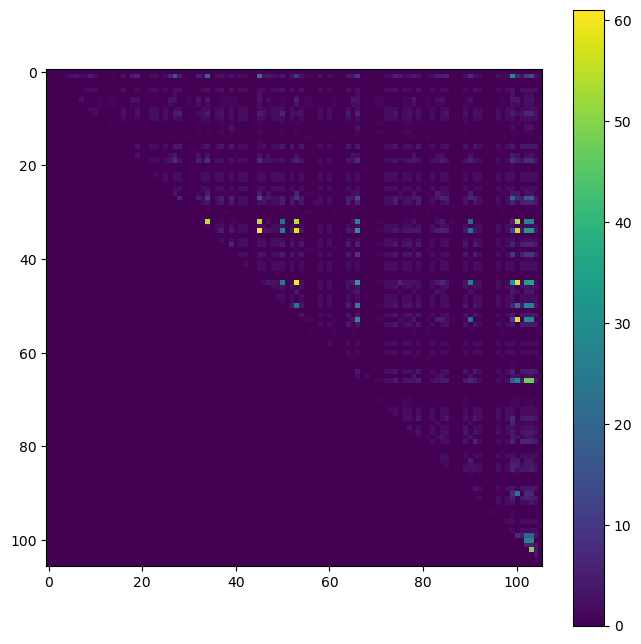

(34, 45)
Actors who are co-mediators to the greatest number of mediations: ['Ethiopia', 'IGAD']
Number of mediations: 61



In [7]:
%run ./mediation_functions.py

# Get the co-occurrence matrix
co_matrices = get_cooccurrence_matrices(data_dict['matrix'])

actor_upper = np.triu(co_matrices[0],k=1)
print(actor_upper.shape)

f = plt.figure(figsize=(8,8))
plt.imshow(actor_upper)
plt.colorbar()
plt.show()

# Actors with max mediations between them
indices = np.unravel_index(np.argmax(actor_upper,axis=None),actor_upper.shape)
print(indices)
actors = [data_dict['actor_vertices'][index] for index in indices]
print('Actors who are co-mediators to the greatest number of mediations:',actors)
print('Number of mediations:',actor_upper[indices])
print()


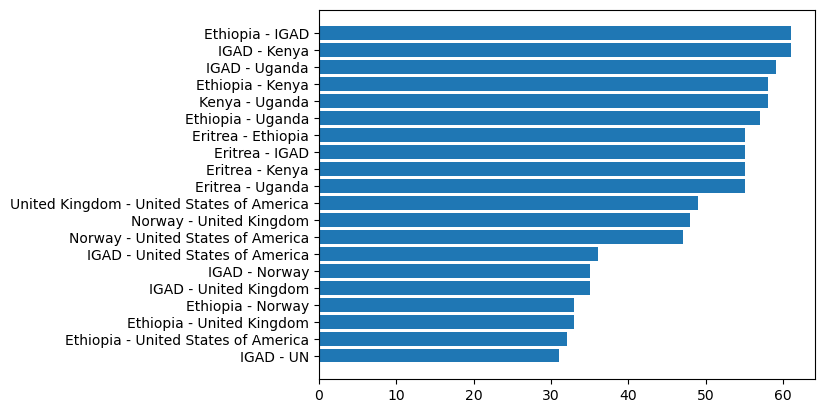

In [10]:
rc = np.nonzero(actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))


scores = [(data_dict['actor_vertices'][t[0]],data_dict['actor_vertices'][t[1]],\
           actor_upper[t[0]][t[1]]) for t in z]
scores = sorted(scores,key=lambda t:t[2],reverse=True)

n = 20
plt.barh(range(0,n),[t[2] for t in scores[0:n]])
plt.yticks(range(0,n),[t[0] + ' - ' + t[1] for t in scores[0:n]])
plt.gca().invert_yaxis()
plt.show()


### Recover co-occurence data for highest scoring co-mediators

In [21]:
actors = [data_dict['actor_vertices'][index] for index in indices]
actor_indices = [data_dict['actor_vertices'].index(actor_id) for actor_id in actors]

# Number in co-occurrence cell
#print(co_matrices[0][actor_indices[0]][actor_indices[1]])

bin_matrix = (data_dict['matrix'] > 1).astype(np.int8)
# Get the row from the transpose of pp matrix
row1 = bin_matrix.T[actor_indices[0]]
# Get row 2 from the matrix
row2 = bin_matrix.T[actor_indices[1]]

x = np.bitwise_and(row1,row2)

mediation_data = []
for index,value in enumerate(x): 
    if value == 1:
        mediation_id = data_dict['mediation_vertices'][index]
        mediation_data.append((index,mediation_id,data_dict['vertices_dict'][mediation_id]['data']))
mediation_data = sorted(mediation_data, key=lambda t:t[2]['year'])

print(len(mediation_data))
print()
for data in mediation_data[0:10]:
    index = data[0]
    edge_dict_1 =\
        recover_edge_dict(data_dict['matrix'][index,actor_indices[0]],len(get_empty_edge_dict()))
    edge_dict_2 =\
        recover_edge_dict(data_dict['matrix'][index,actor_indices[1]],len(get_empty_edge_dict()))

    print(data[1],data[2])
    print(actors[0],edge_dict_1)
    print(actors[1],edge_dict_2)
    print()


61

10 {'year': '1994', 'conflict_locale': 'Sudan', 'neg_location': 'Kenya', 'neg_type': 'R'}
Ethiopia {'is_lead': '0', 'good_offices': '0', 'mediation': '1', 'hosting': '0', 'negotiating': '0', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}
IGAD {'is_lead': '1', 'good_offices': '0', 'mediation': '1', 'hosting': '1', 'negotiating': '0', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}

11 {'year': '1994', 'conflict_locale': 'Sudan', 'neg_location': 'Kenya', 'neg_type': 'R'}
Ethiopia {'is_lead': '0', 'good_offices': '0', 'mediation': '0', 'hosting': '0', 'negotiating': '1', 'manipulating': '1', 'humanitarian': '0', 'witness': '0', 'other': '0'}
IGAD {'is_lead': '1', 'good_offices': '0', 'mediation': '0', 'hosting': '1', 'negotiating': '1', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}

12 {'year': '1994', 'conflict_locale': 'Sudan', 'neg_location': 'Kenya', 'neg_type': 'R'}
Ethiopia {'is_lead': '0', 'good_offices'

### Roles heatmap for a pair of actors

How are roles distributed between a pair of co-occurrence actors?


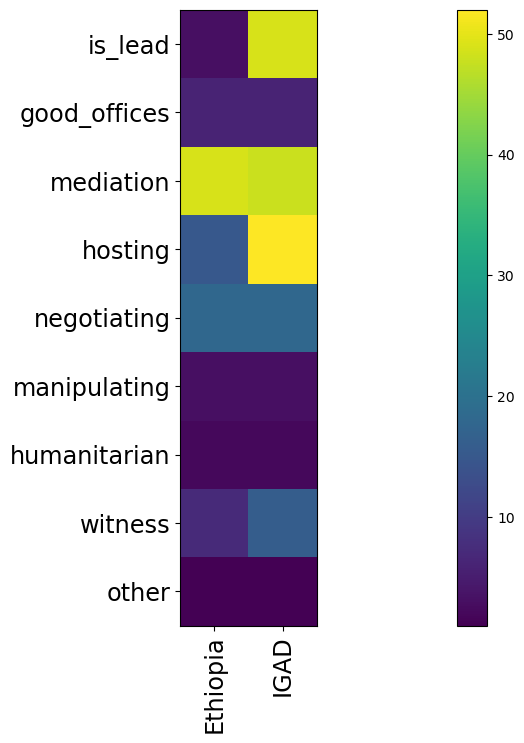

In [14]:
actors = [data_dict['actor_vertices'][index] for index in indices]
actor_indices = [data_dict['actor_vertices'].index(actor_id) for actor_id in actors]

# Number in co-occurrence cell
#print(co_matrices[0][actor_indices[0]][actor_indices[1]])

bin_matrix = (data_dict['matrix'] > 1).astype(np.int8)
# Get the row from the transpose of pp matrix
row1 = bin_matrix.T[actor_indices[0]]
# Get row 2 from the matrix
row2 = bin_matrix.T[actor_indices[1]]

x = np.bitwise_and(row1,row2)

mediation_data = []
for index,value in enumerate(x): 
    if value == 1:
        mediation_id = data_dict['mediation_vertices'][index]
        mediation_data.append((index,mediation_id,data_dict['vertices_dict'][mediation_id]['data']))
mediation_data = sorted(mediation_data, key=lambda t:t[2]['year'])

# Build matrix with roles in columns and actors in columns
e_dict = get_empty_edge_dict()

role_keys = list(e_dict.keys())

roles_matrix = np.zeros([len(e_dict),2]).astype(np.int_)

for data in mediation_data:
    index = data[0]
    edge_dict_1 = recover_edge_dict(data_dict['matrix'][index,actor_indices[0]],len(e_dict))
    values = list(edge_dict_1.values())
    for i,v in enumerate(values):
        roles_matrix[i,0] += int(v)
        
    edge_dict_2 = recover_edge_dict(data_dict['matrix'][index,actor_indices[1]],len(e_dict))
    values = list(edge_dict_2.values())
    for i,v in enumerate(values):
        roles_matrix[i,1] += int(v)

f = plt.figure(figsize=(36,8))
plt.imshow(roles_matrix)
plt.colorbar()
plt.yticks(range(0,len(role_keys)),role_keys,fontsize='xx-large')
plt.xticks(range(0,len(actors)),actors,fontsize='xx-large',rotation=90)
plt.show()


## Actor data

### Mediations

In [15]:
# Recover the mediations and the edge data
actor_id = 'IGAD'
print('Mediation engagements for:',actor_id, data_dict['vertices_dict'][actor_id]['type'])
mediation_data = get_mediations(actor_id,data_dict)
mediation_data = sorted(mediation_data, key=lambda t:t[2])
print('Total mediation engagements:',len(mediation_data))

k = 0
for t in mediation_data:
    edge_dict = recover_edge_dict(t[1],len(get_empty_edge_dict()))
    values = list(edge_dict.values())
    for i,v in enumerate(values):
        k += int(v)
print('Total mediation roles:',k)
print()

for t in mediation_data[0:10]:
    print(t[0],data_dict['vertices_dict'][t[0]]['data'])
    edge_dict = recover_edge_dict(t[1],len(get_empty_edge_dict()))
    print(edge_dict)
    print()



Mediation engagements for: IGAD R
Total mediation engagements: 100
Total mediation roles: 296

358 {'year': '1993', 'conflict_locale': 'Sudan', 'neg_location': 'Ethiopia', 'neg_type': 'R'}
{'is_lead': '1', 'good_offices': '0', 'mediation': '1', 'hosting': '0', 'negotiating': '1', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}

7 {'year': '1993', 'conflict_locale': 'Sudan', 'neg_location': 'Nigeria', 'neg_type': 'R'}
{'is_lead': '0', 'good_offices': '1', 'mediation': '1', 'hosting': '0', 'negotiating': '1', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}

10 {'year': '1994', 'conflict_locale': 'Sudan', 'neg_location': 'Kenya', 'neg_type': 'R'}
{'is_lead': '1', 'good_offices': '0', 'mediation': '1', 'hosting': '1', 'negotiating': '0', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}

11 {'year': '1994', 'conflict_locale': 'Sudan', 'neg_location': 'Kenya', 'neg_type': 'R'}
{'is_lead': '1', 'good_offices': '0', 'mediat

### Roles

- Mediation roles of actor
- Aggregated over years


Mediation engagements for: IGAD R
Total mediation engagements: 100
Total mediation roles: 296



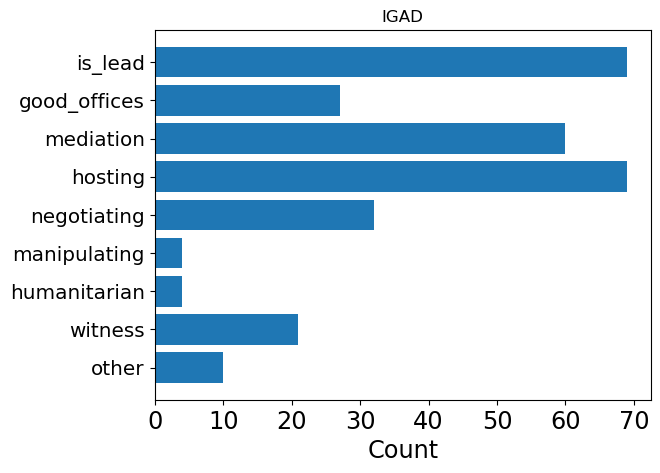

In [16]:

actor_id = 'IGAD'
print('Mediation engagements for:',actor_id, data_dict['vertices_dict'][actor_id]['type'])
mediation_data = get_mediations(actor_id,data_dict)
mediation_data = sorted(mediation_data, key=lambda t:t[2])
print('Total mediation engagements:',len(mediation_data))
role_counts = [0]*len(get_empty_edge_dict())

for t in mediation_data:
    edge_dict = recover_edge_dict(t[1],len(get_empty_edge_dict()))
    values = list(edge_dict.values())
    for i,v in enumerate(values):
        role_counts[i] += int(v)

print('Total mediation roles:',sum(role_counts))
print()

plt.barh(range(0,len(role_counts)),role_counts)
plt.yticks(range(0,len(role_keys)),role_keys,fontsize='x-large')
plt.gca().invert_yaxis()
plt.xticks(fontsize='xx-large')
plt.xlabel('Count',fontsize='xx-large')
plt.title(actor_id)
plt.show()


### Year

- Mediation engagements per year for actor
- Keep same actor ID


Total mediation engagements: 100


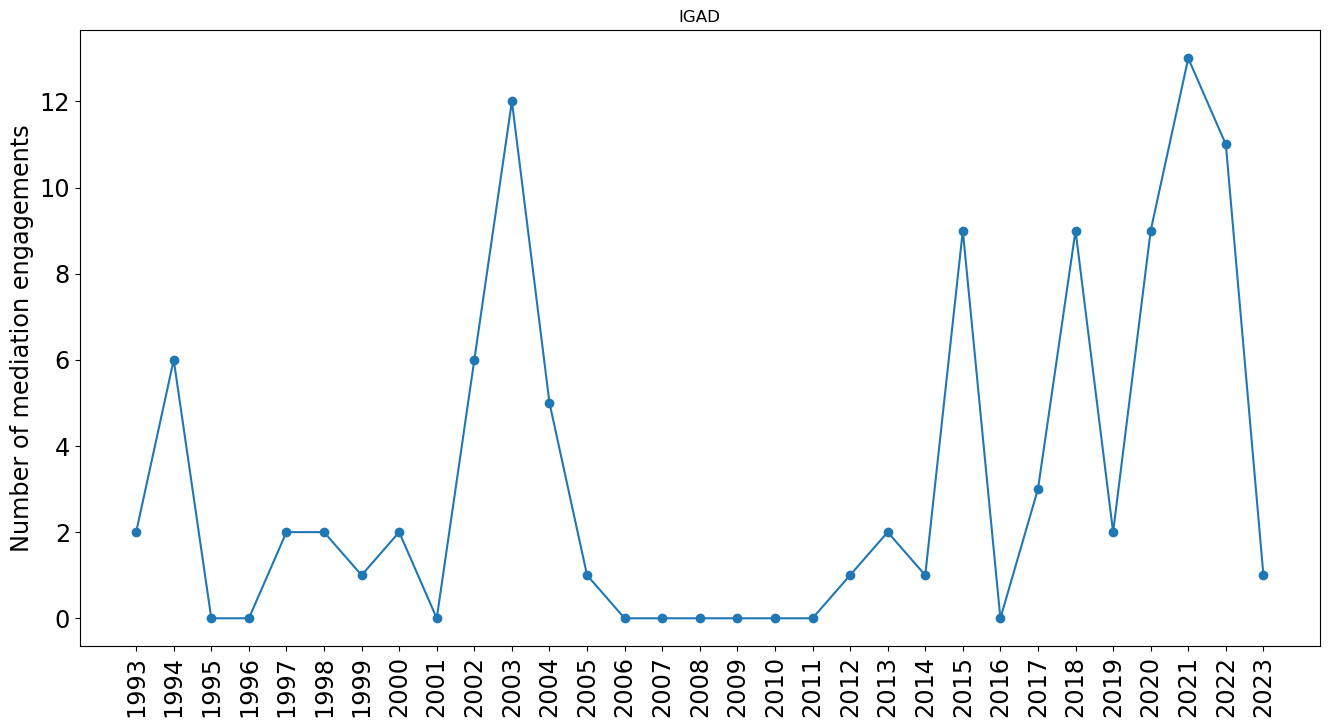

In [17]:
years = sorted(list(set([int(t[2]) for t in mediation_data])))

year_range = list(range(min(years),max(years)+1,1))

year_counts = [0]*len(year_range)

for data in mediation_data:
    year = int(data[2])
    edge_dict = recover_edge_dict(t[1],len(get_empty_edge_dict()))
    values = list(edge_dict.values())
    #for i,v in enumerate(values):
    year_counts[year_range.index(year)] += 1

print()
print('Total mediation engagements:',sum(year_counts))

f = plt.figure(figsize=(16,8))
plt.plot(year_range,year_counts)
plt.scatter(year_range,year_counts)
plt.xticks(year_range,year_range,fontsize='xx-large',rotation=90)
plt.yticks(fontsize='xx-large')
plt.ylabel('Number of mediation engagements',fontsize='xx-large')
plt.title(actor_id)
plt.show()

### Role-year matrix

(9, 31)
Total mediation roles: 296



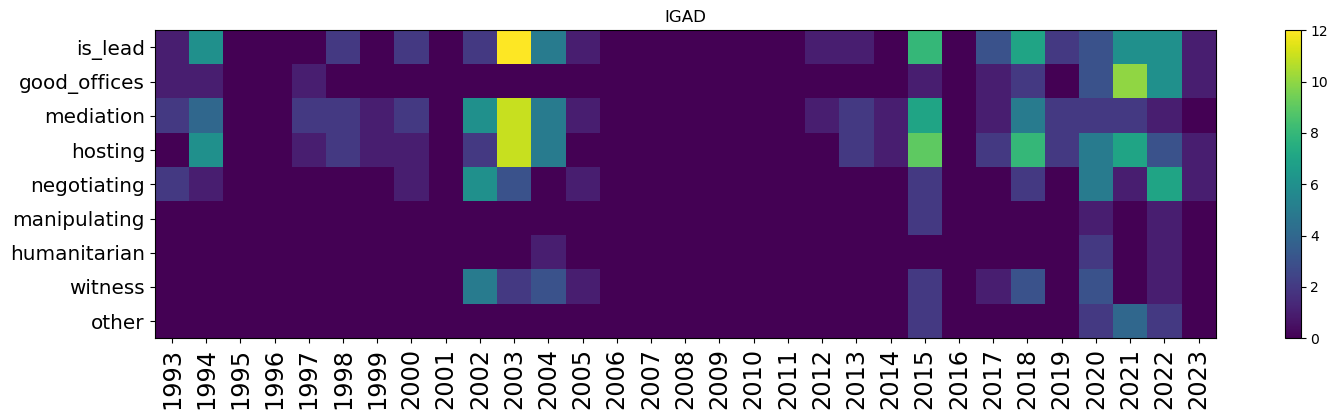

In [18]:
role_year_matrix = np.zeros([len(get_empty_edge_dict()),len(year_range)]).astype(np.int_)

for t in mediation_data:
    year = int(t[2])
    col_index = year_range.index(year)
    
    edge_dict = recover_edge_dict(t[1],len(get_empty_edge_dict()))
    values = list(edge_dict.values())
    for i,v in enumerate(values):
        if int(v) > 0:
            role_year_matrix[i,col_index] += 1

print(role_year_matrix.shape)

k = 0
for row in role_year_matrix:
    for v in row:
        k+=v
print('Total mediation roles:',k)
print()
        
f = plt.figure(figsize=(18,4))
plt.imshow(role_year_matrix)
plt.colorbar()
plt.yticks(range(0,len(role_keys)),role_keys,fontsize='x-large')
plt.xticks(range(0,len(year_range)),year_range,fontsize='xx-large',rotation=90)
plt.title(actor_id)
plt.show()



## Mediation data

### Actors engaged in a mediation

In [19]:
mediation_id = '10'
mediation_index = data_dict['mediation_vertices'].index(mediation_id)
mediation_data = data_dict['vertices_dict'][mediation_id]['data']

print(mediation_id,mediation_data)
print()

row = data_dict['matrix'][mediation_index]
for i,v in enumerate(row):
    if v > 0:
        edge_dict = recover_edge_dict(v,len(get_empty_edge_dict()))
        print(data_dict['actor_vertices'][i],edge_dict)
        


10 {'year': '1994', 'conflict_locale': 'Sudan', 'neg_location': 'Kenya', 'neg_type': 'R'}

Eritrea {'is_lead': '0', 'good_offices': '0', 'mediation': '1', 'hosting': '0', 'negotiating': '0', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}
Ethiopia {'is_lead': '0', 'good_offices': '0', 'mediation': '1', 'hosting': '0', 'negotiating': '0', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}
IGAD {'is_lead': '1', 'good_offices': '0', 'mediation': '1', 'hosting': '1', 'negotiating': '0', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}
Kenya {'is_lead': '0', 'good_offices': '0', 'mediation': '1', 'hosting': '1', 'negotiating': '0', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}
Uganda {'is_lead': '0', 'good_offices': '0', 'mediation': '1', 'hosting': '0', 'negotiating': '0', 'manipulating': '0', 'humanitarian': '0', 'witness': '0', 'other': '0'}


## Data integrity checks

### Actor data

- Is the lead actor always part for the set of mediation

In [ ]:
actor_dict = {}

header = data_dict['header']
actor_vertices = data_dict['actor_vertices']

for i,row in enumerate(data_dict['data']):        
    mediation_id = row[header.index('mediation ID')]
    actor = row[header.index('third-party')].strip()
    if not actor in actor_vertices:
        print(mediation_id,actor)
    lead = row[header.index('leading actor')].strip()
    if not lead in actor_vertices:
        print('LEAD',mediation_id,lead)
    lead2 = row[header.index('leading actor 2')].strip()
    if len(lead2) > 0 and not lead2 in actor_vertices:
        print('LEAD2',mediation_id,lead2)
    lead3 = row[header.index('leading actor 3')].strip()
    if len(lead3) > 0 and not lead3 in actor_vertices:
        print('LEAD2',mediation_id,lead3)


### Mediation data

In [ ]:
# Check integrity of mediation data

mediation_dict = {}

header = data_dict['header']

for i,row in enumerate(data_dict['data']):
    mediation_id = row[header.index('mediation ID')]
    if not mediation_id in mediation_dict:
        mediation_dict[mediation_id] = {}
        mediation_dict[mediation_id]['year'] = []
        mediation_dict[mediation_id]['conflict_locale'] = []
        mediation_dict[mediation_id]['conflict_sublocale'] = []
        mediation_dict[mediation_id]['negotiation_location'] = []
        mediation_dict[mediation_id]['negotiation_type'] = []
    
    year = row[header.index('year')]
    if not year in mediation_dict[mediation_id]['year']:
        mediation_dict[mediation_id]['year'].append(year)
    locale = row[header.index('conflict locale')]    
    if not locale in mediation_dict[mediation_id]['conflict_locale']:
        mediation_dict[mediation_id]['conflict_locale'].append(locale)
    sublocale = row[header.index('conflict sub-locale')]    
    if not sublocale in mediation_dict[mediation_id]['conflict_sublocale']:
        mediation_dict[mediation_id]['conflict_sublocale'].append(sublocale)
    location = row[header.index('location of neogitations')]    
    if not location in mediation_dict[mediation_id]['negotiation_location']:
        mediation_dict[mediation_id]['negotiation_location'].append(location)
    ntype = row[header.index('negotiation type')]    
    if not ntype in mediation_dict[mediation_id]['negotiation_type']:
        mediation_dict[mediation_id]['negotiation_type'].append(ntype)
    
# Do any lists have multiple values
for k,inner in mediation_dict.items():
    for l,v in inner.items():
        if len(v) > 1:
            print(k,l,v)

